In [2]:
%pip install scikit-learn -q
%pip install pandas -q
%pip install numpy -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install keras -q
%pip install os -q

%pip install cvxopt -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn import preprocessing, model_selection
import random
import seaborn as sns
import os
import cvxEDA
import pickle

In [4]:

MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/"

QUALITY_THRESHOLD = 128
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2

In [5]:
dataset = pd.read_csv(DATA_PATH + "/merged_data.csv")

In [6]:
import pandas as pd

# Function to create sequences DataFrame
def create_sequences_df(dataset, max_length=128):
    sequences = []
    temp_sequence = []
    eda_sequence = []
    label = None
    time_sequence = []
    current_id = None

    for index, row in dataset.iterrows():
        if current_id != row['ID']:
            # New ID encountered, append previous sequence to list
            if temp_sequence:
                sequences.append({
                    'ID': current_id,
                    'w_eda': eda_sequence,
                    'w_temp': temp_sequence,
                    'downsampled_label': label,
                    'Time': time_sequence
                })
            # Reset sequences for new ID
            temp_sequence = [row['w_temp']]
            eda_sequence = [row['w_eda']]
            label = row['downsampled_labels']
            time_sequence = [row['Time']]
            current_id = row['ID']
        else:
            # Append values to sequences
            temp_sequence.append(row['w_temp'])
            eda_sequence.append(row['w_eda'])
            time_sequence.append(row['Time'])

        # Check if sequence length exceeds max_length
        if len(temp_sequence) >= max_length:
            sequences.append({
                'ID': current_id,
                'w_eda': eda_sequence,
                'w_temp': temp_sequence,
                'downsampled_label': label,
                'Time': time_sequence
            })
            # Reset sequences for new ID
            temp_sequence = []
            eda_sequence = []
            label = None
            time_sequence = []
            current_id = None

    # Append last sequence if it's not empty
    if temp_sequence:
        sequences.append({
            'ID': current_id,
            'w_eda': eda_sequence,
            'w_temp': temp_sequence,
            'downsampled_label': label,
            'Time': time_sequence
        })

    # Convert list of dictionaries to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

# Create sequences DataFrame
sequences_df = create_sequences_df(dataset)

# Check the resulting DataFrame
sequences_df.loc[88]

ID                                                                  S2
w_eda                [1.068966, 1.07281, 1.076654, 1.074091, 1.0728...
w_temp               [32.77, 32.77, 32.77, 32.77, 32.77, 32.77, 32....
downsampled_label                                                  2.0
Time                 [2816.0, 2816.25, 2816.5, 2816.75, 2817.0, 281...
Name: 88, dtype: object

In [7]:
print(sequences_df.loc[88, 'w_eda'])


[1.068966, 1.07281, 1.076654, 1.074091, 1.07281, 1.074091, 1.077935, 1.080498, 1.080498, 1.080498, 1.085623, 1.09203, 1.108687, 1.13047, 1.14969, 1.165066, 1.174035, 1.181723, 1.184286, 1.181723, 1.175317, 1.16891, 1.165066, 1.158659, 1.152253, 1.144565, 1.134314, 1.125345, 1.120219, 1.121501, 1.126626, 1.133033, 1.138158, 1.144565, 1.148409, 1.153534, 1.162503, 1.162503, 1.161222, 1.161222, 1.157378, 1.154815, 1.154815, 1.150971, 1.147127, 1.145846, 1.144565, 1.143283, 1.140721, 1.131751, 1.127907, 1.127907, 1.133033, 1.131751, 1.135595, 1.135595, 1.135595, 1.139439, 1.140721, 1.142002, 1.142002, 1.138158, 1.138158, 1.135595, 1.134314, 1.133033, 1.13047, 1.13047, 1.127907, 1.125345, 1.124063, 1.122782, 1.121501, 1.120219, 1.120219, 1.118938, 1.118938, 1.109969, 1.104843, 1.100999, 1.102281, 1.112531, 1.122782, 1.122782, 1.134314, 1.148409, 1.159941, 1.167629, 1.159941, 1.156097, 1.154815, 1.154815, 1.153534, 1.153534, 1.150971, 1.147127, 1.144565, 1.139439, 1.136877, 1.131751, 1.12790

In [8]:
print(sequences_df)

       ID                                              w_eda  \
0      S2  [1.138257, 1.125444, 1.011405, 1.033188, 0.935...   
1      S2  [1.289355, 1.289355, 1.288074, 1.288074, 1.286...   
2      S2  [0.962616, 0.958772, 0.94724, 0.943396, 0.9369...   
3      S2  [1.135595, 1.131751, 1.131751, 1.129189, 1.126...   
4      S2  [1.011306, 1.008744, 1.007462, 1.006181, 1.006...   
...   ...                                                ...   
2715  S17  [1.012345, 1.005948, 1.004668, 1.00083, 0.9995...   
2716  S17  [1.003389, 0.995713, 0.996992, 0.993154, 0.995...   
2717  S17  [0.981639, 0.976522, 0.97908, 0.97908, 0.98036...   
2718  S17  [0.963728, 0.95861, 0.965007, 0.976522, 0.9765...   
2719  S17  [0.931742, 0.929184, 0.933022, 0.929184, 0.931...   

                                                 w_temp  downsampled_label  \
0     [35.41, 35.41, 35.41, 35.41, 35.41, 35.41, 35....                0.0   
1     [35.45, 35.45, 35.45, 35.45, 35.45, 35.45, 35....                0.0 

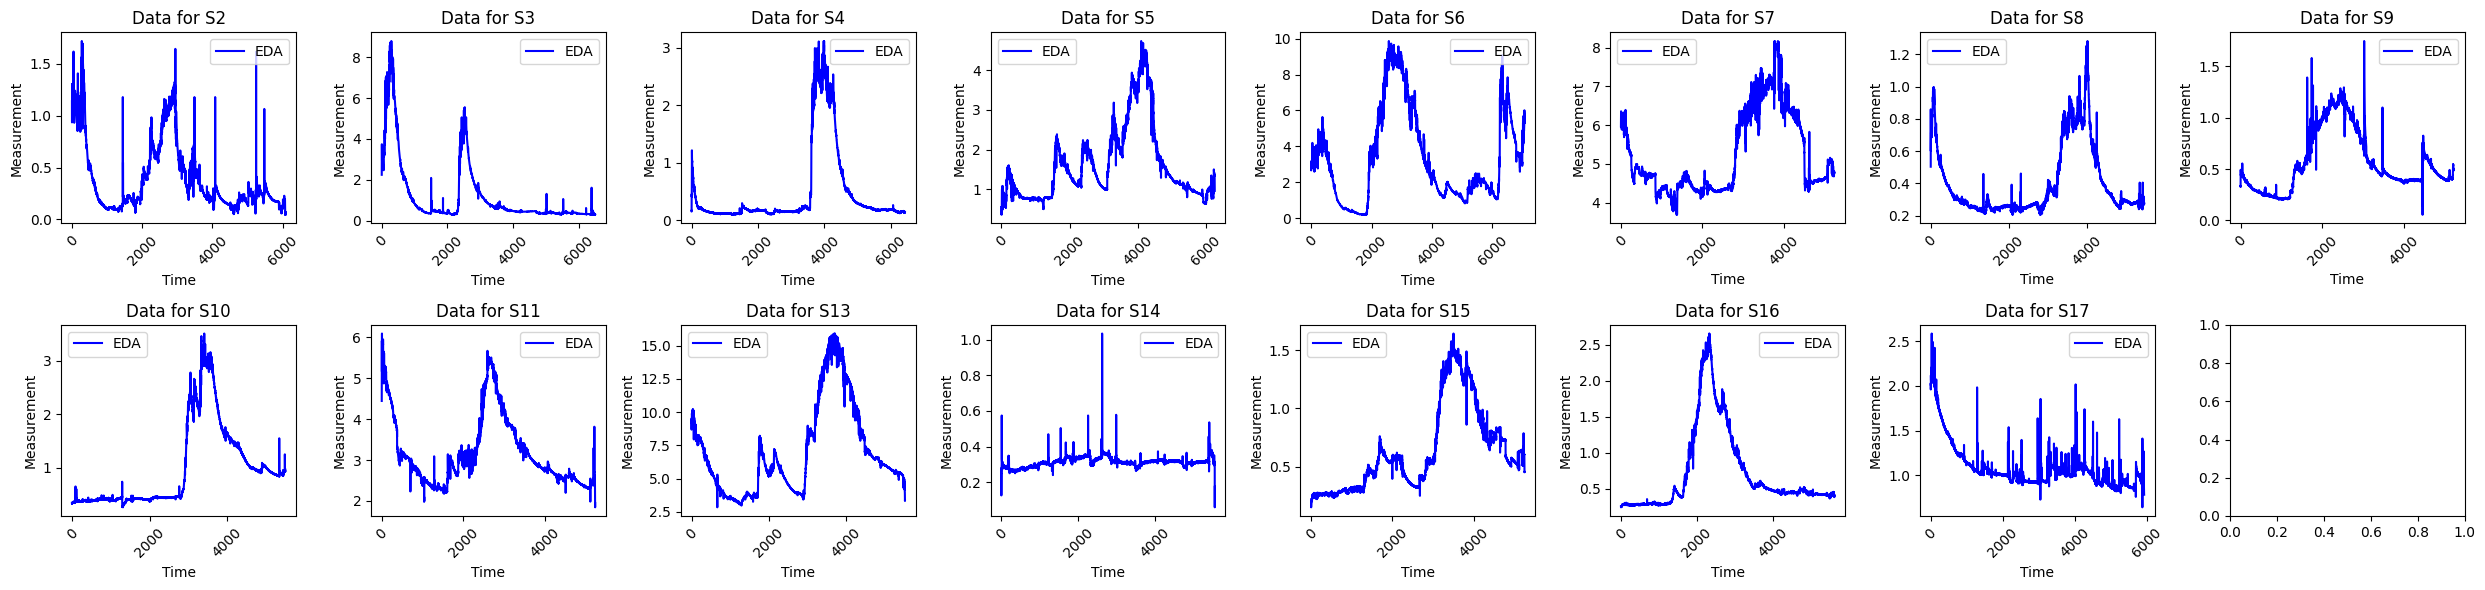

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(2, 8, figsize=(25, 6))  # Increased figure size
axes = axes.flatten()

# Define unique_ids
unique_ids = dataset['ID'].unique()

# Iterate through each unique id
for i, unique_id in enumerate(unique_ids):
    if i < len(unique_ids):
        # Filter data for each id
        subset_data = dataset[dataset['ID'] == unique_id]
        
        # Plotting
        sns.lineplot(x='Time', y='w_eda', data=subset_data, ax=axes[i], color='blue', label='EDA')
        # sns.lineplot(x='Time', y='w_temp', data=subset_data, ax=axes[i], color='red', label='Temp')

        axes[i].set_title(f"Data for {unique_id}")
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Measurement')
        axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
print("Before replacing labels")
unique_labels_before = sequences_df['downsampled_label'].unique()
print(unique_labels_before, "\n")
print("Number of unique labels before replacement:", len(unique_labels_before), "\n")


Before replacing labels
[0. 1. 2. 4. 3.] 

Number of unique labels before replacement: 5 



In [11]:
sequences_df["downsampled_label"] = sequences_df["downsampled_label"].apply(lambda x: 1 if x == 2.0 else 0)
sequences_df.loc[88]

ID                                                                  S2
w_eda                [1.068966, 1.07281, 1.076654, 1.074091, 1.0728...
w_temp               [32.77, 32.77, 32.77, 32.77, 32.77, 32.77, 32....
downsampled_label                                                    1
Time                 [2816.0, 2816.25, 2816.5, 2816.75, 2817.0, 281...
Name: 88, dtype: object

In [12]:
from sklearn import preprocessing

print("After replacing labels")
unique_labels_after = sequences_df["downsampled_label"].unique()
print(unique_labels_after)
print("Number of unique labels after replacement:", len(unique_labels_after))

le = preprocessing.LabelEncoder()  # Generates a look-up table
le.fit(sequences_df["downsampled_label"])
sequences_df['downsampled_label'] = le.transform(sequences_df["downsampled_label"])


After replacing labels
[0 1]
Number of unique labels after replacement: 2


In [13]:
num_classes = len(sequences_df['downsampled_label'].unique())
print(num_classes)


2


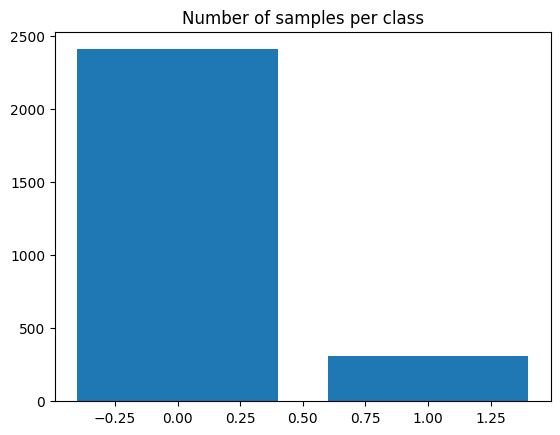

In [14]:
plt.bar(range(num_classes), sequences_df['downsampled_label'].value_counts())
plt.title("Number of samples per class")
plt.show()


****Scale and split data****

We perform a simple Min-Max scaling to bring the value-range between 0 and 1. We do not use Standard Scaling as the data does not follow a Gaussian distribution.

In [15]:
# Scale the 'w_eda' feature
scaler = preprocessing.MinMaxScaler()
eda_series_list = [
    scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in sequences_df["w_eda"]
]

# temp_series_list = [
#     scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in sequences_df["w_temp"]
# ]


# # Combine EDA and temperature series
# combined_series_list = [
#     np.concatenate((eda_series, temp_series), axis=1)
#     for eda_series, temp_series in zip(eda_series_list, temp_series_list)
# ]
# Separate the labels
labels_list = [i for i in sequences_df['downsampled_label']]

# print(len(combined_series_list))
print(len(eda_series_list))
print(len(labels_list))


2720
2720


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combine EDA and temperature series


# Padding sequences to ensure uniform length
max_sequence_length = 128  # Choose the desired maximum sequence length
padded_series_list = pad_sequences(eda_series_list, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    padded_series_list, labels_list, test_size=0.30, random_state=42, shuffle=True
)

# Convert to numpy arrays and reshape for compatibility with Keras
x_train = np.asarray(x_train).astype(np.float32).reshape(-1, max_sequence_length, 1)  # Assuming 2 features (EDA and TEMP)
y_train = np.asarray(y_train).astype(np.float32).reshape(-1, 1)
y_train = keras.utils.to_categorical(y_train)

x_test = np.asarray(x_test).astype(np.float32).reshape(-1, max_sequence_length, 1)  # Assuming 2 features (EDA and TEMP)
y_test = np.asarray(y_test).astype(np.float32).reshape(-1, 1)
y_test = keras.utils.to_categorical(y_test)

# Check lengths of train and test sets
print(
    f"Length of x_train : {len(x_train)}\nLength of x_test : {len(x_test)}\nLength of y_train : {len(y_train)}\nLength of y_test : {len(y_test)}"
)


Length of x_train : 1904
Length of x_test : 816
Length of y_train : 1904
Length of y_test : 816


In [17]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [18]:
vals_dict = {}
for i in sequences_df['downsampled_label']:
    if i in vals_dict.keys():
        vals_dict[i] += 1
    else:
        vals_dict[i] = 1
total = sum(vals_dict.values())

# Formula used - Naive method where
# weight = 1 - (no. of samples present / total no. of samples)
# So more the samples, lower the weight

weight_dict = {k: (1 - (v / total)) for k, v in vals_dict.items()}
print(weight_dict)



{0: 0.11470588235294121, 1: 0.8852941176470588}


In [19]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [20]:
def create_model():
    input_layer = keras.Input(shape=(128, 1))

    x = layers.Conv1D(
        filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(
        filters=1024,
        kernel_size=7,
        strides=2,
        activation="relu",
        padding="same",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(0.2)(x)

    # Add Flatten layer after the last convolutional layer
    x = layers.Flatten()(x)
    print("Shape after Flatten:", x.shape)
    
    x = layers.Dense(4096, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        2048, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(
        1024, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(
        128, activation="relu", kernel_regularizer=keras.regularizers.L2()
    )(x)
    output_layer = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=input_layer, outputs=output_layer)

In [21]:
conv_model = create_model()
conv_model.summary()

# Save model to JSON
# Done for Kevin Bevers for his Headless CMS Stress platform prototype project
model_json = conv_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


Shape after Flatten: (None, 2048)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 8, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 4, 512)         │       918,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2, 1024)        │     3,671,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 1024)        │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       131,20

 Total params: 23,821,634 (90.87 MB)

 Trainable params: 23,817,602 (90.86 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [22]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=0.000001,
    ),
]

optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
loss = keras.losses.BinaryCrossentropy()


In [23]:
conv_model.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(),  # BinaryAccuracy for binary classification
        keras.metrics.AUC(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
    ],
)

conv_model_history = conv_model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_dataset,
    class_weight=weight_dict,
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - auc: 0.5460 - binary_accuracy: 0.5280 - loss: 26.7042 - precision: 0.5280 - recall: 0.5280 - val_auc: 0.1058 - val_binary_accuracy: 0.1017 - val_loss: 2.9813 - val_precision: 0.1017 - val_recall: 0.1017 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - auc: 0.6873 - binary_accuracy: 0.6740 - loss: 1.4990 - precision: 0.6740 - recall: 0.6740 - val_auc: 0.0942 - val_binary_accuracy: 0.1017 - val_loss: 1.0253 - val_precision: 0.1017 - val_recall: 0.1017 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - auc: 0.8349 - binary_accuracy: 0.7542 - loss: 0.2867 - precision: 0.7542 - recall: 0.7542 - val_auc: 0.0938 - val_binary_accuracy: 0.1017 - val_loss: 0.9472 - val_precision: 0.1017 - val_recall: 0.1017 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - auc: 0.7986 - binary_accuracy: 0.7089 - loss: 0.1480 - precision: 0.7089 - recall: 0.7089 - val_auc: 0.8

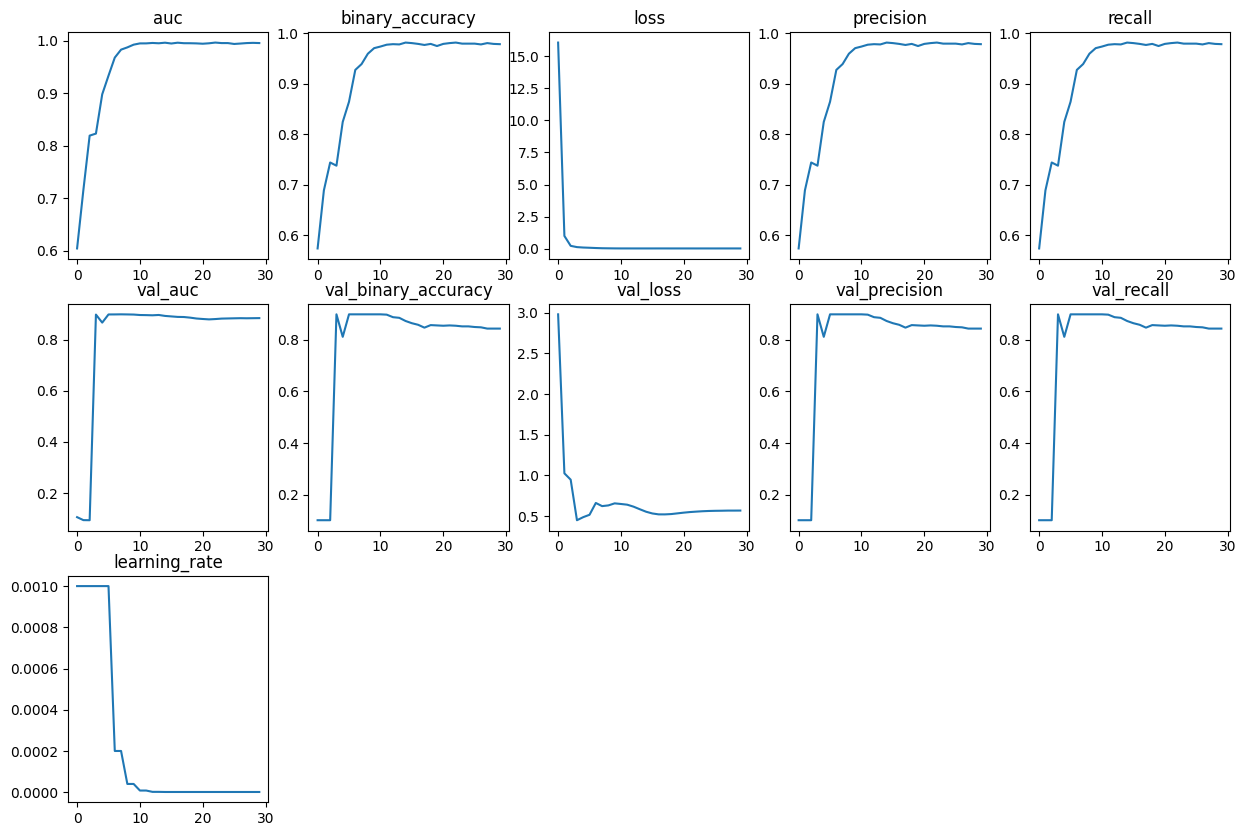

In [26]:
plot_history_metrics(conv_model_history)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8815 - binary_accuracy: 0.8370 - loss: 0.5706 - precision: 0.8370 - recall: 0.8370
Loss : 0.5672851204872131
Top 3 Categorical Accuracy : 0.8838742971420288
Area under the Curve (ROC) : 0.843137264251709
Precision : 0.843137264251709
Recall : 0.843137264251709


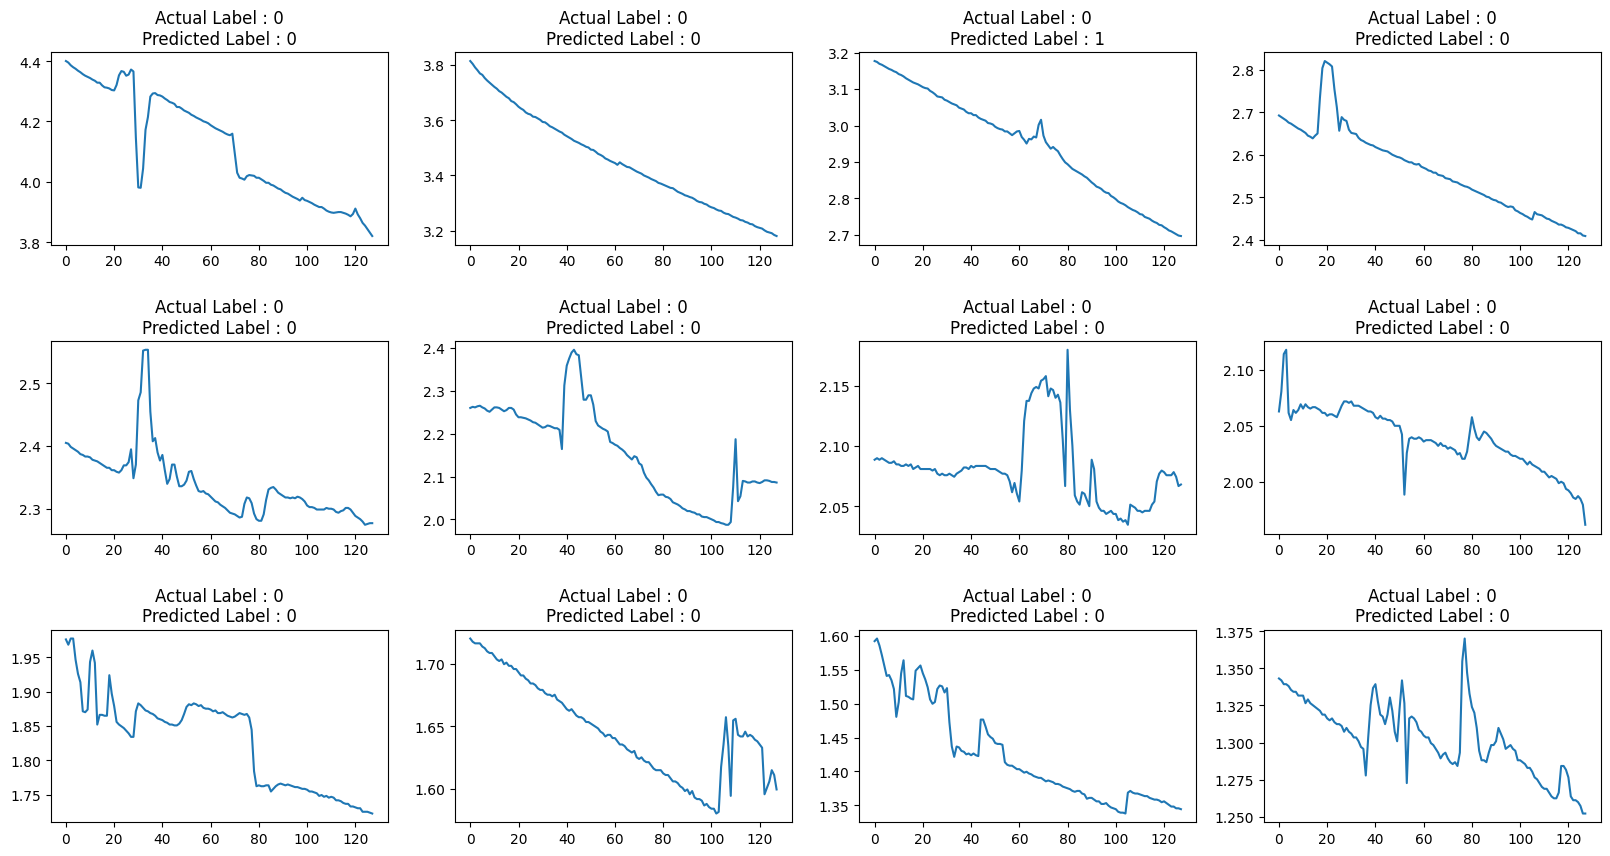

In [27]:
loss, accuracy, auc, precision, recall = conv_model.evaluate(test_dataset)
print(f"Loss : {loss}")
print(f"Top 3 Categorical Accuracy : {accuracy}")
print(f"Area under the Curve (ROC) : {auc}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")


def view_evaluated_eeg_plots(model):
    start_index = random.randint(10, len(sequences_df))
    end_index = start_index + 11
    data = sequences_df.loc[start_index:end_index, 'w_eda']
    data_array = [scaler.fit_transform(np.asarray(i).reshape(-1, 1)) for i in data]
    data_array = [np.asarray(data_array).astype(np.float32).reshape(-1, 128, 1)]
    original_labels = sequences_df.loc[start_index:end_index, 'downsampled_label']
    predicted_labels = np.argmax(model.predict(data_array, verbose=0), axis=1)
        
    total_plots = 12
    cols = total_plots // 3
    rows = total_plots // cols
    if total_plots % cols != 0:
        rows += 1
    pos = range(1, total_plots + 1)
    fig = plt.figure(figsize=(20, 10))
    for i, (plot_data, og_label, pred_label) in enumerate(
        zip(data, original_labels, predicted_labels)
    ):
        plt.subplot(rows, cols, pos[i])
        plt.plot(plot_data)
        plt.title(f"Actual Label : {og_label}\nPredicted Label : {pred_label}")
        fig.subplots_adjust(hspace=0.5)
    plt.show()

view_evaluated_eeg_plots(conv_model)